In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, random_split
from torchvision import transforms
import visdom
from torch.nn import init as init
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.io
import math

In [2]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
num_step = 20 #step can 20、40 (5 years、10years)
num_window = 4
num_predict_window = 1
img_n = 16
img_h = 8

In [ ]:
class CustomDataset_plus(Dataset):
    def __init__(self, label_dir):
        self.label_dir = os.path.join(label_dir, "S")
        self.refine_well_dir = os.path.join(label_dir, "Well")
        self.K_dir = os.path.join(label_dir, "K")
        self.Pore_dir = os.path.join(label_dir, "Pore")
        self.Pressure_dir = os.path.join(label_dir, "Pressure")
        

        self.refine_file_list = os.listdir(self.refine_well_dir)
        self.K_file_list = os.listdir(self.K_dir)
        self.Pore_file_list = os.listdir(self.Pore_dir)
        self.Pressure_file_list = os.listdir(self.Pressure_dir)
        
        self.label_file_list = os.listdir(self.label_dir )
        

    def __len__(self):
        return len(self.label_file_list)

    def __getitem__(self, index):
        file_index = index
        rotation_index = index
        refine_file_name = self.refine_file_list[file_index]
        K_file_name = self.K_file_list[file_index]
        
        Pore_file_name = self.Pore_file_list[file_index]
        Pressure_file_name = self.Pressure_file_list[file_index]
        
        label_file_name = self.label_file_list[file_index]
        
        refine_file_path = os.path.join(self.refine_well_dir, refine_file_name)
        K_file_path = os.path.join(self.K_dir, K_file_name)
        Pore_file_path = os.path.join(self.Pore_dir, Pore_file_name)
        Pressure_file_path = os.path.join(self.Pressure_dir, Pressure_file_name)
        
        label_file_path = os.path.join(self.label_dir, label_file_name)
        
        K_data = scipy.io.loadmat(K_file_path)
        K_array = (np.log(K_data['K']))
        K_tensor = torch.from_numpy(K_array).reshape(1,img_n,img_n,img_h).to(device2).float()
        
        Pore_data = scipy.io.loadmat(Pore_file_path)
        Pore_array = Pore_data['p']
        Pore_tensor = torch.from_numpy(Pore_array).reshape(1,img_n,img_n,img_h).to(device2).float()
        
        Pressure_data = scipy.io.loadmat(Pressure_file_path)
        Pressure_array = (Pressure_data['pressure'])
        Pressure_tensor = torch.from_numpy(Pressure_array.transpose(3,0,1,2))[:num_step].to(device2).float()* 1e-7  / 2. 
        Pressure_tensor = torch.rot90(Pressure_tensor, k=rotation_index, dims=(1, 2))
      
        
        # Label file for reading label data
        label_data = scipy.io.loadmat(label_file_path)
        # Extract the array to be converted
        label_array = label_data['Ssmatrix']
        
        #Get the well location of the refine [16, 16, 8]
        label_refine_well = torch.from_numpy(scipy.io.loadmat(refine_file_path)["wc_globale_refine"]).to(device2).float() #用于loss使用
        
        input_refine_well = label_refine_well.reshape(1,img_n,img_n,img_h).to(device2).float()
        
         # Conditions to be added
        intermediate_condition = torch.cat([F.normalize(K_tensor,dim=0),F.normalize(Pore_tensor,dim=0),input_refine_well],axis=0)
        intermediate_condition = torch.rot90(intermediate_condition, k=rotation_index, dims=(1, 2))
        
        # Convert NumPy arrays to PyTorch 
        label_tensor = torch.from_numpy(label_array.transpose(3,4,0,1,2))[:,:num_step].to(device2)
        label_tensor = torch.rot90(label_tensor, k=rotation_index, dims=(2, 3))
        return  (label_tensor).float(),(intermediate_condition).float(),Pressure_tensor.float()

# Create customized dataset instances
label_dir = './CO2Datasets/refine/' 
dataset = CustomDataset_plus(label_dir)


_, valid_dataset = random_split(dataset, [0, 1])

# Use the data loader to load the training and validation sets
batch_size = 1
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv3d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)

In [6]:
#DoubleConv-does not change channel by default, residual-controls whether or not to utilize residual network
class DoubleConv(nn.Module):
    def __init__(self,in_c,out_c,mid_c=None,residual=False):
        super().__init__()
        self.residual = residual
        
        if not mid_c:
            mid_c = out_c
            
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_c,mid_c,kernel_size=3,padding=1),
            nn.GroupNorm(1,mid_c),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_c,out_c,kernel_size=3,padding=1),
            nn.GroupNorm(1,out_c)
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self,x):
        if self.residual:
            return self.relu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

# downsampling
class Down(nn.Module):
    def __init__(self, in_channels , out_channels , down_t):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
        nn.MaxPool3d(2),
        DoubleConv(in_channels , in_channels, residual=True),
        DoubleConv(in_channels, out_channels),
        )
        #Learning the embedding process with models
        self.maxpool_conv_t = nn.Sequential(
            nn.MaxPool3d(down_t),
            DoubleConv(num_window, out_channels),
        )
        
    def forward(self,x,t):
        x = self.maxpool_conv(x)
        t = self.maxpool_conv_t(t)
        return x + t

#upsampling
class Up(nn.Module):
    def __init__ (self,in_channels, out_channels, down_t):
        super().__init__()
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels,residual=True),
            DoubleConv(in_channels, out_channels,in_channels//2),
        )
        self.maxpool_conv_t = nn.Sequential(
            nn.MaxPool3d(down_t),
            DoubleConv(num_window, out_channels),
        )
    def forward(self,x, skip_x,t):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.cat([skip_x,x],dim=1)
        x= self.conv(x)
        t = self.maxpool_conv_t(t)
        return x + t
    
#Fully convoluted self-attenion
class ConvAttentionBlock_2C(nn.Module):
    def __init__(self, nf=64, bias=True):
        super(ConvAttentionBlock_2C,self).__init__()
        self.nf = nf
        self.convQ1 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convK1 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convV1 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convQ2 = nn.Conv3d(nf, nf, 3,1,1)
        self.convV3 = nn.Conv3d(nf, nf, 3, 1,1)
        self.relu = nn.ReLU(inplace=True)
        self.instance_norm = nn.InstanceNorm3d(nf)
        self.convTurn1 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convTurn2= nn.Conv3d(nf, nf, 3, 1,1)
        self.convK2 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convV2 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convQ3 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convK3 = nn.Conv3d(nf, nf, 3,  1,1)
        self.convTurn3 = nn.Conv3d(nf, nf, 3, 1,1)
        self.convTurn = nn.Conv3d(nf, nf, 3, 1,1)
         # initialization
        default_init_weights([self.convTurn1,self.convTurn2,self.convTurn3,self.convTurn,self.convQ1,self.convK1,self.convV1 ,self.convQ2,self.convK2,self.convV2 ,self.convQ3,self.convK3,self.convV3,self.convTurn], 0.1)
    
    def forward(self, x):
        m = x.size(2)
        h = x.size(4)
        size = m*m*h
        Q1 = self.convQ1(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf)
        K1 = self.convK1(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf).permute(0, 2, 1)
        V1= self.convV1(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf)
        Q2 = self.convQ2(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf)
        K2 = self.convK2(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf).permute(0, 2, 1)
        V2= self.convV2(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf)
        Q3 = self.convQ3(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf)
        K3 = self.convK3(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf).permute(0, 2, 1)
        V3= self.convV3(x).permute((0, 2, 3, 4, 1)).view(-1,size,self.nf)
        
        B1 = (self.convTurn1(torch.bmm( V1 , self.relu((torch.bmm(K1, Q1)/math.sqrt(self.nf)).float()) ).permute(0, 2, 1).view(-1,self.nf,m,m,h)))
        B2 = (self.convTurn2(torch.bmm( V2 , self.relu((torch.bmm(K2, Q2)/math.sqrt(self.nf)).float()) ).permute(0, 2, 1).view(-1,self.nf,m,m,h)))
        B3 = (self.convTurn3(torch.bmm( V3 , self.relu((torch.bmm(K3, Q3)/math.sqrt(self.nf)).float()) ).permute(0, 2, 1).view(-1,self.nf,m,m,h)))
        
        x = self.instance_norm(self.convTurn(x + (0.3 * (B1+B2+B3))))
        
        return x


class ConvAttention(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf):
        super(ConvAttention, self).__init__()
        self.CAB1 = ConvAttentionBlock_2C(nf)
        self.CAB2 = ConvAttentionBlock_2C(nf)
        self.conv1 = nn.Conv3d(nf, nf, 3, 1,1)
        self.conv2 = nn.Conv3d(nf, nf, 3, 1,1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        
        out = self.CAB1(x)
        x = self.relu(self.conv1(x + out)) 
        out = self.CAB2(x)
        x = self.relu(self.conv2(x + out)) 
        return x

In [7]:
class FCUNet(nn.Module):
    def __init__(self,c_in=8+4+3,c_out_s=2*num_predict_window,c_out_p = num_predict_window):
        super().__init__()
        
        self.inc = DoubleConv(c_in,8)
        self.down1 = Down(8,16,2)
        self.sa1 = ConvAttention(16)
        self.down2 = Down(16,32,4)
        self.sa2 = ConvAttention(32)
        self.down3 = Down(32,64,8)
        self.sa3 = ConvAttention(64)
        
        self.bot1 = DoubleConv(64,128)
        self.bot2 = DoubleConv(128,128)
        self.bot3 = DoubleConv(128,64)
        
        self.up1 = Up(64+32,32,4)
        self.sa4 = ConvAttention(32)
        self.up2 = Up(32+16,16,2)
        self.sa5 = ConvAttention(16)
        
        self.up3_s = Up(16+8,16,1)
        self.up3_p = Up(16+8,8,1)
        self.out_s = nn.Conv3d(16,c_out_s,kernel_size=1,stride=1,padding=0)
        self.out_p = nn.Conv3d(8,c_out_p,kernel_size=1,stride=1,padding=0)
    def forward(self,x,t):
        #Downsampling process and use of self-attention mechanism
        x1 = self.inc(x)
        x2 = self.down1(x1,t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2,t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3,t)
        x4 = self.sa3(x4)
        
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        #Up-sampling process, self-attention before skip-connect 
        x = self.up1(x4,x3,t)
        x = self.sa4(x)
        x = self.up2(x,x2,t)
        x = self.sa5(x)
        x_s = self.up3_s(x,x1,t)
        x_p = self.up3_p(x,x1,t)
        x_s = self.out_s(x_s)
        x_p = self.out_p(x_p)
        return torch.cat([x_s,x_p],dim=1) 

In [8]:
def MRE(matrix1,matrix2):    
    # Calculate the absolute value difference and obtain the relative error 
    # (use the absolute value error for points where the true value is 0)
    diff = torch.abs(matrix1 - matrix2)
    relative_error = diff / (torch.abs(matrix1) + 1e-8)

    # Replace the relative error for points with a true value of 0 with the absolute value error
    mask_zero = (matrix1 == 0)
    relative_error[mask_zero] = diff[mask_zero]

    return relative_error

In [9]:
def GetOutputs(model):
    # Iteratively generate all the predictions
    #Put each prediction into sequence_saturation and output_pressure.
    #Take the output of each prediction as the input for the next prediction e.g. if each prediction outputs 1 step, 
    # then the next input will be the 2nd, 3rd, 4th, 5th step to predict the 6th step.
    model.eval()
    num_iters = (num_step-num_window)/num_predict_window
    step = [np.ones((img_n,img_n,img_h)) * i for i in range(num_step-num_predict_window)]
    step_emb = torch.from_numpy(np.concatenate(step, axis=0).reshape(num_step-num_predict_window,img_n,img_n,img_h)/ num_step).float()
    targets ,intermidates,Pressure= batch[0].to(device2), batch[1].to(device2),batch[2].to(device2)
    sequence_saturation = torch.zeros_like(targets)
    sequence_pressure = torch.zeros_like(Pressure)
    sequence_saturation[:,:,:num_window,:,:,:] = targets[:,:,:num_window,:,:,:]
    sequence_pressure[:,:num_window,:,:,:] = Pressure[:,:num_window,:,:,:]
    for s in range(int(num_iters)):
        begin = s*num_predict_window
        t = step_emb[begin:(num_window+begin),:,:,:].reshape(num_window,img_n,img_n,img_h).to(device2).repeat(targets.size(0),1,1,1,1)
        tar_saturation = targets[:,:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:].reshape(-1,2*num_predict_window,img_n,img_n,img_h)
        tar_pressure = Pressure[:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:].reshape(-1,num_predict_window,img_n,img_n,img_h)
        tar = torch.cat([tar_saturation,tar_pressure],dim=1)
        saturation = sequence_saturation[:,:,begin:(num_window+begin),:,:,:].reshape(-1,2*num_window,img_n,img_n,img_h)
        pressure = sequence_pressure[:,begin:(num_window+begin),:,:,:].reshape(-1,num_window,img_n,img_n,img_h)
        inputs = torch.cat([saturation,pressure,intermidates],dim=1)
        outputs = model(inputs,t)
        output_saturation = outputs[:,:2*num_predict_window,:,:,:].detach()
        output_pressure = outputs[:,2*num_predict_window:,:,:,:].detach()
        output_saturation[output_saturation <= 0.02] = 0
        output_saturation[output_saturation >= 0.99] = 1
        targets[targets <= 0.02] = 0
        targets[targets >= 0.99] = 1
        sequence_saturation[:,:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:] = output_saturation.reshape(-1,2,num_predict_window,img_n,img_n,img_h)
        sequence_pressure[:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:] = output_pressure
    return sequence_saturation,sequence_pressure*2./1e-7,targets,Pressure*2./1e-7

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def show_result_s(b,step,layer,outputs_s,outputs_p,targets,pressure,l1loss):   
    
    # Calculate relative error
    relative_error = MRE(targets[0, : , : , : , : ,:],outputs_s[0, : , : , : , : ,:])
    # Get the slice to display
    outputs_show = outputs_s[0, 1,step, :, :,layer].detach().cpu().numpy()
    targets_show = targets[0, 1,step, :, :,layer].detach().cpu().numpy()
    relative_error_show = relative_error[1,step, :, :,layer].detach().cpu().numpy()
    # Calculate MAE and MRE for every step
    if step<0:
        mae = []
        mre = []
        for i in range(num_step):
            mae.append(loss_fn(outputs_s[0, :,i, :, :,:],targets[0, :,i, :, :,:]).item())
            mre.append(torch.mean(relative_error[:,i, :, :,:]).item())
        result = np.round(np.array(mae), decimals=4)
        print("MAE\n")
        print(result,result.mean(),result[7],result[11],result[15],result[-1],torch.abs(outputs_s - targets).min(),torch.abs(outputs_s - targets).max())
        print("MRE\n")
        res = np.round(np.array(mre), decimals=4)
        print(res,res.mean(),res[7],res[11],res[15],res[-1],relative_error[:,i, :, :,:].min(),relative_error[:,i, :, :,:].max())
        l1loss.append(result[4:].mean()) 
    fig, axs = plt.subplots(1, 4, figsize=(16, 14))

    cmap = plt.cm.get_cmap('rainbow')
    cmap_colors = cmap(np.arange(cmap.N))
    cmap_colors[0] = [1.0, 1.0, 1.0, 1.0] 
    new_cmap = colors.ListedColormap(cmap_colors)
    

    #display the results simulated by traditional methods
    im0 = axs[0].imshow(targets_show, cmap=new_cmap,vmin=0, vmax=1)
    cbar0 = plt.colorbar(im0, ax=axs[0], shrink=0.2) 
    axs[0].tick_params(axis='both', which='both', labelsize=6)
    cbar0.ax.tick_params(labelsize=20)
    #display the results predicted by the model
    im2 = axs[1].imshow(outputs_show, cmap=new_cmap,vmin=0, vmax=1)
    cbar1 = plt.colorbar(im2, ax=axs[1],shrink=0.2) 
    axs[1].tick_params(axis='both', which='both', labelsize=6)
    cbar1.ax.tick_params(labelsize=20)
    #display absoluted error
    im3 = axs[2].imshow(np.abs(targets_show - outputs_show), cmap=new_cmap,vmin=0, vmax=0.2)
    cbar2 = plt.colorbar(im3, ax=axs[2],shrink=0.2)
    axs[2].tick_params(axis='both', which='both', labelsize=6)
    cbar2.ax.tick_params(labelsize=20)
    #display relative error
    im4 = axs[3].imshow(relative_error_show, cmap=new_cmap,vmin=0, vmax=1)
    cbar3 = plt.colorbar(im4, ax=axs[3],shrink=0.2)
    axs[3].tick_params(axis='both', which='both', labelsize=6)
    cbar3.ax.tick_params(labelsize=20)
    plt.tight_layout()
    show3d_result_s(model,step,outputs_s,targets,relative_error)
    plt.show()

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
#Same as the code above that shows the saturation
def show_result_p(b,step,layer,outputs_s,outputs_p,targets,pressure,l1loss):
    relative_error = MRE(pressure[0 , : , : , : ,:],outputs_p[0 , : , : , : ,:])
    outputs_show = outputs_p[0,step, :, :,layer].detach().cpu().numpy()
    targets_show = pressure[0,step, :, :,layer].detach().cpu().numpy()
    relative_error_show = relative_error[step, :, :,layer].detach().cpu().numpy()
    if step<0:
        mae = []
        mre = []
        for i in range(num_step):
            mae.append(loss_fn(outputs_p[0,i, :, :,:],pressure[0,i, :, :,:]).item())
            mre.append(torch.mean(relative_error[i, :, :,:]).item())
        result = np.round(np.array(mae), decimals=4)
        print("MAE\n")
        print(result,result.mean(),result[7],result[11],result[15],result[-1],torch.abs(outputs_s - targets).min(),torch.abs(outputs_s - targets).max())
        print("MRE\n")
        res = np.round(np.array(mre), decimals=4)
        print(res,res.mean(),res[7],res[11],res[15],res[-1],relative_error[i, :, :,:].min(),relative_error[i, :, :,:].max())
        l1loss.append(result[4:].mean()) 
    fig, axs = plt.subplots(1, 4, figsize=(16, 14))
    cmap = plt.cm.get_cmap('rainbow')
    cmap_colors = cmap(np.arange(cmap.N))
    cmap_colors[0] = [1.0, 1.0, 1.0, 1.0] 
    new_cmap = colors.ListedColormap(cmap_colors)
    

    
    im0 = axs[0].imshow(targets_show, cmap=new_cmap)
    cbar0 = plt.colorbar(im0, ax=axs[0], shrink=0.18)
    axs[0].tick_params(axis='both', which='both', labelsize=6)
    cbar0.ax.tick_params(labelsize=20)

    
    im2 = axs[1].imshow(outputs_show, cmap=new_cmap)
    cbar1 = plt.colorbar(im2, ax=axs[1],shrink=0.18) 
    axs[1].tick_params(axis='both', which='both', labelsize=6)
    cbar1.ax.tick_params(labelsize=20)
    
    im3 = axs[2].imshow(np.abs(targets_show - outputs_show), cmap=new_cmap)
    cbar2 = plt.colorbar(im3, ax=axs[2],shrink=0.18) 
    axs[2].tick_params(axis='both', which='both', labelsize=6)
    cbar2.ax.tick_params(labelsize=20)
    
    im4 = axs[3].imshow(relative_error_show, cmap=new_cmap)
    cbar3 = plt.colorbar(im4, ax=axs[3],shrink=0.18)
    axs[3].tick_params(axis='both', which='both', labelsize=6)
    cbar3.ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.show()


In [12]:
import matplotlib.cm as cm
#Demonstrate 3-D saturation
def show3d_result_s(model_pre,step,outputs,targets,relative_error):
    outputs_show = np.flip(outputs[0,1,step, :, :,:].detach().cpu().numpy(), axis=-1)
    targets_show = np.flip(targets[0, 1,step, :, :,:].detach().cpu().numpy(), axis=-1)
    relative_error_show = np.flip(relative_error[1,step, :, :,:].detach().cpu().numpy(), axis=-1)

    # Colorize the data using the rainbow color mapper
    colors1 = cm.rainbow(targets_show)
    colors2 = cm.rainbow(outputs_show)
    error = np.abs(targets_show - outputs_show)
    colors3 = cm.rainbow(error)
    colors4 = cm.rainbow(relative_error_show)
    fig = plt.figure(figsize=(13, 12))

    ax1 = fig.add_subplot(141, projection='3d')
    ax1.voxels(targets_show, facecolors=colors1, linewidth=0.1)
    ax1.set_aspect('auto')
    cbar1 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax1, shrink=0.12)
    cbar1.ax.tick_params(labelsize=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax2 = fig.add_subplot(142, projection='3d')
    ax2.voxels(outputs_show, facecolors=colors2, linewidth=0.1)
    ax2.set_aspect('auto')
    cbar2 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax2, shrink=0.12)
    cbar2.ax.tick_params(labelsize=10)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax3 = fig.add_subplot(143, projection='3d')
    ax3.voxels(np.abs(targets_show-outputs_show), facecolors=colors3, linewidth=0.1)
    ax3.set_aspect('auto')
    cbar3 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax3, shrink=0.12)
    cbar3.ax.tick_params(labelsize=10)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_zticks([])
    
    ax4 = fig.add_subplot(144, projection='3d')
    ax4.voxels(relative_error_show, facecolors=colors4, linewidth=0.1)
    ax4.set_aspect('auto')
    cbar4 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax4, shrink=0.12)
    cbar4.ax.tick_params(labelsize=10)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_zticks([])
    plt.tight_layout()
    plt.show()

In [13]:
import matplotlib.cm as cm
# Showing pressure in three dimensions
def show3d_result_p(model_pre,step,outputs,targets,relative_error):
    outputs_show = np.flip(outputs[0,step, :, :,:].detach().cpu().numpy(), axis=-1)
    targets_show = np.flip(targets[0,step, :, :,:].detach().cpu().numpy(), axis=-1)
    relative_error_show = np.flip(relative_error[step, :, :,:].detach().cpu().numpy(), axis=-1)

    colors1 = cm.rainbow(targets_show)
    colors2 = cm.rainbow(outputs_show)
    error = np.abs(targets_show - outputs_show)
    colors3 = cm.rainbow(error)
    colors4 = cm.rainbow(relative_error_show)
    fig = plt.figure(figsize=(13, 12))

    ax1 = fig.add_subplot(141, projection='3d')
    ax1.voxels(targets_show, facecolors=colors1, linewidth=0.1)
    ax1.set_aspect('auto')
    cbar1 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax1, shrink=0.12)
    cbar1.ax.tick_params(labelsize=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax2 = fig.add_subplot(142, projection='3d')
    ax2.voxels(outputs_show, facecolors=colors2, linewidth=0.1)
    ax2.set_aspect('auto')
    cbar2 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax1, shrink=0.12)
    cbar2.ax.tick_params(labelsize=10)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax3 = fig.add_subplot(143, projection='3d')
    ax3.voxels(np.abs(targets_show-outputs_show), facecolors=colors3, linewidth=0.1)
    ax3.set_aspect('auto')
    cbar3 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax3, shrink=0.12)
    cbar3.ax.tick_params(labelsize=10)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_zticks([])
    
    ax4 = fig.add_subplot(144, projection='3d')
    ax4.voxels(relative_error_show, facecolors=colors4, linewidth=0.1)
    ax4.set_aspect('auto')
    cbar4 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax4)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_zticks([])
    plt.tight_layout()
    plt.show()

In [14]:
model = FCUNet().to(device2)
from torch.nn import DataParallel
# Parallelize the model with DataParallel
model = nn.DataParallel(model, device_ids=[0])
loss_fn = nn.L1Loss()

In [15]:
# Load pre-trained model parameters
pretrained_dict = torch.load('./model4P1/FCUNet.pth',map_location=torch.device('cuda:0')) #pth file path
model_dict = model.state_dict()
# Check and update model parameters
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [16]:
it= iter(valid_loader)

0——————————————————————————


C:\Users\13552\AppData\Local\Temp\ipykernel_4792\152578252.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow')


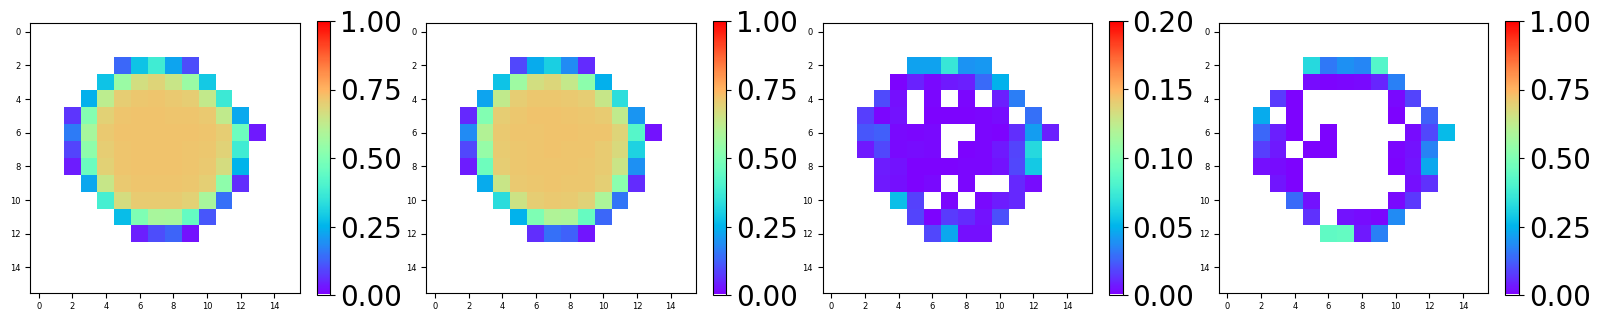

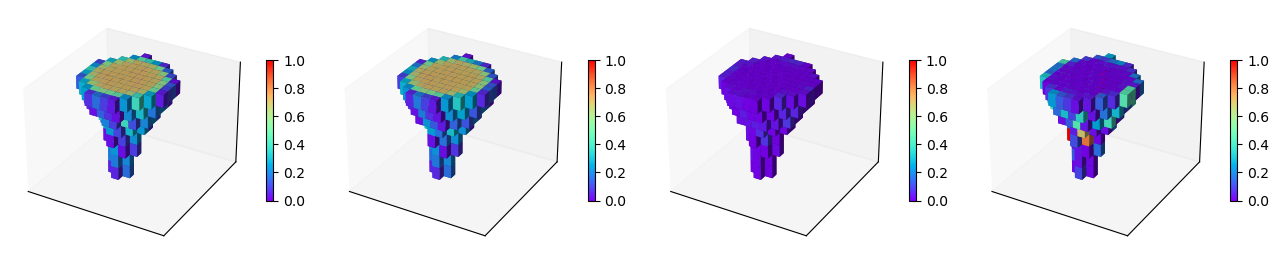

MAE

[0.0001 0.0001 0.0001 0.0001 0.0011 0.0013 0.0014 0.0014 0.0018 0.0019
 0.0023 0.0023 0.0026 0.0026 0.0028 0.0031 0.0034 0.0036 0.0037 0.004 ] 0.001985 0.0014 0.0023 0.0031 0.004 tensor(0., device='cuda:0') tensor(0.1513, device='cuda:0')
MRE

[0.0001 0.0001 0.0001 0.0001 0.0044 0.0046 0.0061 0.0057 0.0071 0.0071
 0.0095 0.0083 0.0093 0.0096 0.0119 0.0133 0.0139 0.0139 0.0146 0.0153] 0.007750000000000002 0.0057 0.0083 0.0133 0.0153 tensor(0., device='cuda:0') tensor(1.8802, device='cuda:0')


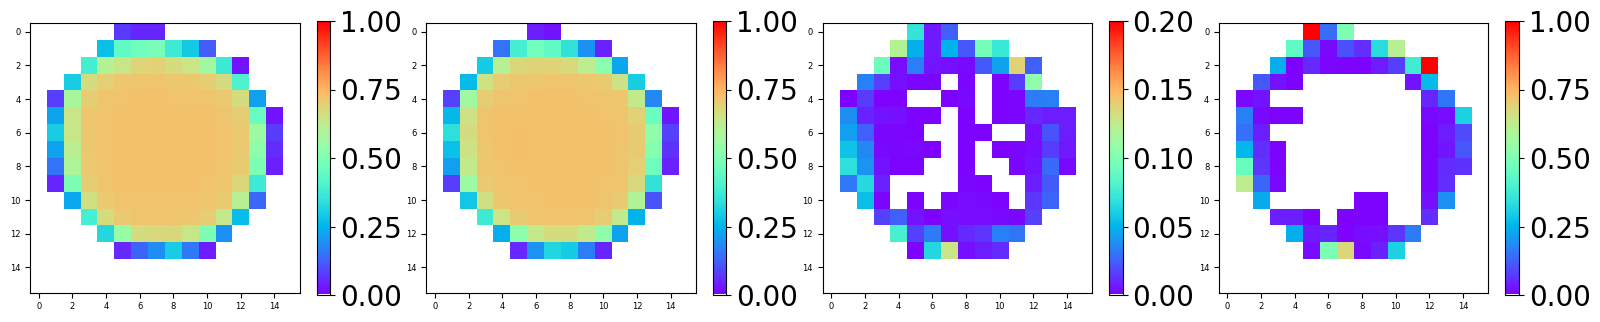

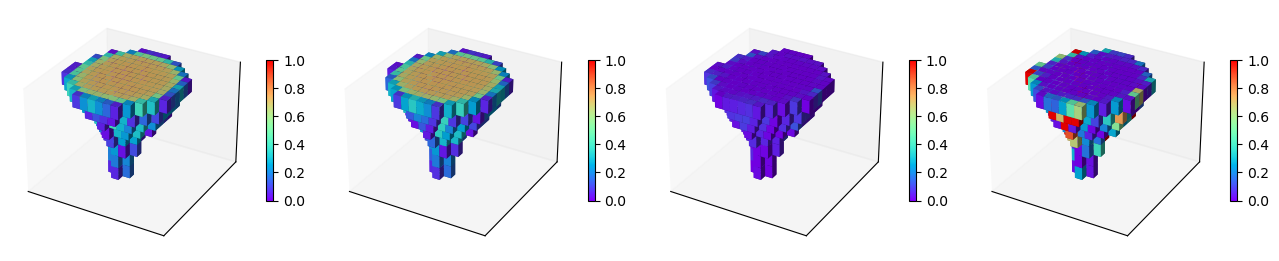

C:\Users\13552\AppData\Local\Temp\ipykernel_4792\2850132912.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow')


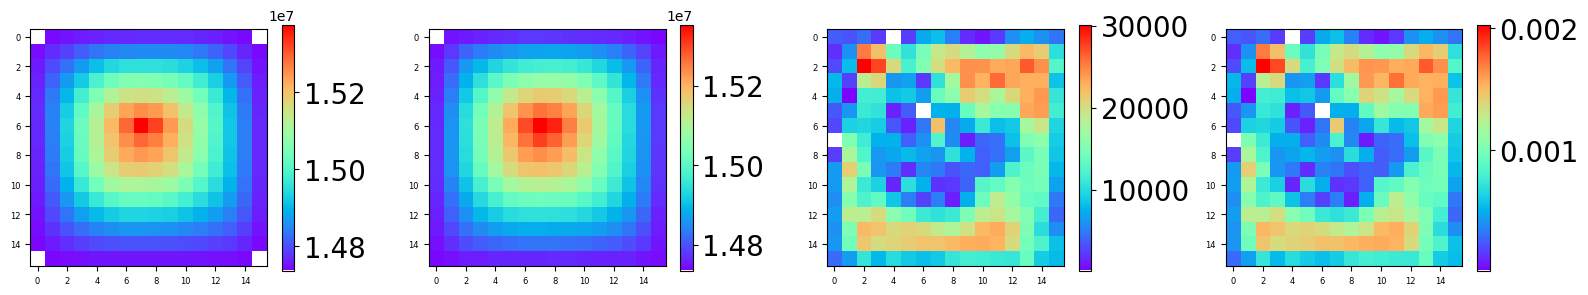

MAE

[    0.         0.         0.         0.     12392.1523 11112.8965
 14185.709  15423.9463 16084.8213 16943.8887 19356.7012 17384.4941
 20396.6523 19440.3516 14679.6689 12629.0938 13141.6504 11567.5
 11037.1289 11013.0332] 11839.484425 15423.9463 17384.4941 12629.0938 11013.0332 tensor(0., device='cuda:0') tensor(0.1513, device='cuda:0')
MRE

[0.     0.     0.     0.     0.0008 0.0007 0.0009 0.001  0.0011 0.0011
 0.0013 0.0011 0.0013 0.0013 0.001  0.0008 0.0009 0.0008 0.0007 0.0007] 0.0007749999999999999 0.001 0.0011 0.0008 0.0007 tensor(1.1531e-06, device='cuda:0') tensor(0.0026, device='cuda:0')


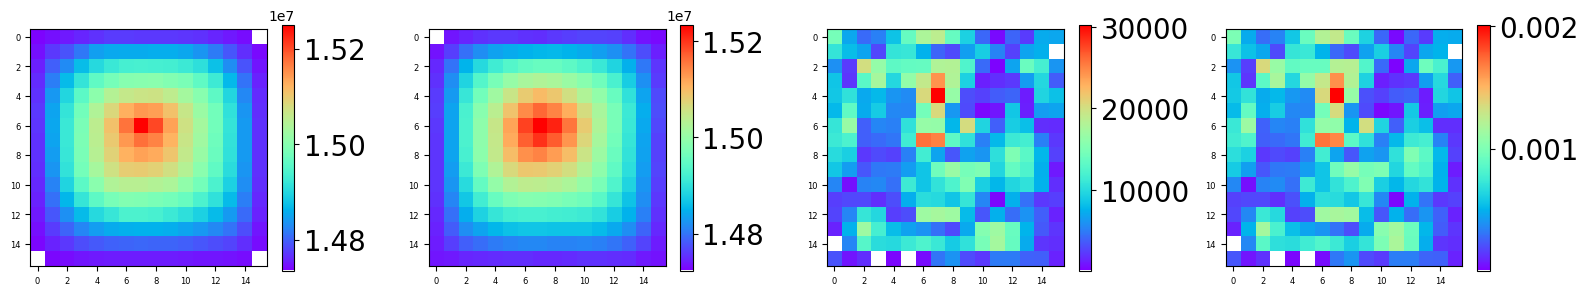

In [17]:
for i in range(len(valid_loader)):
    batch = next(it)
    print(str(i)+"——————————————————————————")
    outputs_s,outputs_p,targets,pressure = GetOutputs(model)
    #The second parameter is the number of steps to be displayed.
    show_result_s(i,9,0,outputs_s,outputs_p,targets,pressure,[])
    show_result_s(i,-1,0,outputs_s,outputs_p,targets,pressure,[])
    show_result_p(i,9,0,outputs_s,outputs_p,targets,pressure,[])
    show_result_p(i,-1,0,outputs_s,outputs_p,targets,pressure,[])
   